In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : True,
    'balance_bins'  : 40,
    'balance_ratio' : 0.5,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_40_1_05_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(734160, 828)
(734160, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/74 [..............................] - ETA: 1:27 - loss: 0.1117 - STD: 3.2291e-04 - MAE: 0.3200

 4/74 [>.............................] - ETA: 1s - loss: 0.0391 - STD: 4.1502e-04 - MAE: 0.1522  

 5/74 [=>............................] - ETA: 2s - loss: 0.0359 - STD: 3.7178e-04 - MAE: 0.1456

 6/74 [=>............................] - ETA: 2s - loss: 0.0342 - STD: 3.3290e-04 - MAE: 0.1430

 7/74 [=>............................] - ETA: 2s - loss: 0.0333 - STD: 2.9992e-04 - MAE: 0.1419

 8/74 [==>...........................] - ETA: 2s - loss: 0.0325 - STD: 2.7251e-04 - MAE: 0.1412

 9/74 [==>...........................] - ETA: 3s - loss: 0.0320 - STD: 2.4948e-04 - MAE: 0.1407

10/74 [===>..........................] - ETA: 3s - loss: 0.0315 - STD: 2.3001e-04 - MAE: 0.1402

11/74 [===>..........................] - ETA: 3s - loss: 0.0310 - STD: 2.1361e-04 - MAE: 0.1394

12/74 [===>..........................] - ETA: 3s - loss: 0.0305 - STD: 1.9965e-04 - MAE: 0.1384

13/74 [====>.........................] - ETA: 3s - loss: 0.0299 - STD: 1.8771e-04 - MAE: 0.1371

14/74 [====>.........................] - ETA: 3s - loss: 0.0293 - STD: 1.7767e-04 - MAE: 0.1353

15/74 [=====>........................] - ETA: 3s - loss: 0.0286 - STD: 1.6931e-04 - MAE: 0.1332

16/74 [=====>........................] - ETA: 3s - loss: 0.0278 - STD: 1.6251e-04 - MAE: 0.1308

17/74 [=====>........................] - ETA: 3s - loss: 0.0270 - STD: 1.5711e-04 - MAE: 0.1282

18/74 [======>.......................] - ETA: 3s - loss: 0.0262 - STD: 1.5292e-04 - MAE: 0.1255

19/74 [======>.......................] - ETA: 2s - loss: 0.0253 - STD: 1.4985e-04 - MAE: 0.1229

20/74 [=======>......................] - ETA: 2s - loss: 0.0245 - STD: 1.4757e-04 - MAE: 0.1204

21/74 [=======>......................] - ETA: 2s - loss: 0.0238 - STD: 1.4593e-04 - MAE: 0.1185

22/74 [=======>......................] - ETA: 2s - loss: 0.0232 - STD: 1.4465e-04 - MAE: 0.1170

23/74 [========>.....................] - ETA: 2s - loss: 0.0227 - STD: 1.4352e-04 - MAE: 0.1159

24/74 [========>.....................] - ETA: 2s - loss: 0.0223 - STD: 1.4239e-04 - MAE: 0.1150

25/74 [=========>....................] - ETA: 2s - loss: 0.0219 - STD: 1.4112e-04 - MAE: 0.1143

26/74 [=========>....................] - ETA: 2s - loss: 0.0216 - STD: 1.3971e-04 - MAE: 0.1137

27/74 [=========>....................] - ETA: 3s - loss: 0.0214 - STD: 1.3815e-04 - MAE: 0.1128

31/74 [===========>..................] - ETA: 2s - loss: 0.0198 - STD: 1.3121e-04 - MAE: 0.1085

32/74 [===========>..................] - ETA: 2s - loss: 0.0195 - STD: 1.2949e-04 - MAE: 0.1074

33/74 [============>.................] - ETA: 2s - loss: 0.0192 - STD: 1.2785e-04 - MAE: 0.1064

34/74 [============>.................] - ETA: 2s - loss: 0.0189 - STD: 1.2630e-04 - MAE: 0.1054

35/74 [=============>................] - ETA: 2s - loss: 0.0187 - STD: 1.2485e-04 - MAE: 0.1045

36/74 [=============>................] - ETA: 2s - loss: 0.0184 - STD: 1.2354e-04 - MAE: 0.1037

37/74 [==============>...............] - ETA: 2s - loss: 0.0182 - STD: 1.2236e-04 - MAE: 0.1029

38/74 [==============>...............] - ETA: 2s - loss: 0.0180 - STD: 1.2128e-04 - MAE: 0.1021

39/74 [==============>...............] - ETA: 2s - loss: 0.0178 - STD: 1.2032e-04 - MAE: 0.1014

40/74 [===============>..............] - ETA: 2s - loss: 0.0176 - STD: 1.1952e-04 - MAE: 0.1008

41/74 [===============>..............] - ETA: 2s - loss: 0.0174 - STD: 1.1882e-04 - MAE: 0.1001

42/74 [================>.............] - ETA: 2s - loss: 0.0172 - STD: 1.1824e-04 - MAE: 0.0995

43/74 [================>.............] - ETA: 2s - loss: 0.0170 - STD: 1.1780e-04 - MAE: 0.0989

44/74 [================>.............] - ETA: 1s - loss: 0.0168 - STD: 1.1744e-04 - MAE: 0.0984

45/74 [=================>............] - ETA: 1s - loss: 0.0166 - STD: 1.1721e-04 - MAE: 0.0979

46/74 [=================>............] - ETA: 1s - loss: 0.0165 - STD: 1.1705e-04 - MAE: 0.0974

47/74 [==================>...........] - ETA: 1s - loss: 0.0163 - STD: 1.1699e-04 - MAE: 0.0970

48/74 [==================>...........] - ETA: 1s - loss: 0.0162 - STD: 1.1697e-04 - MAE: 0.0966

49/74 [==================>...........] - ETA: 1s - loss: 0.0161 - STD: 1.1703e-04 - MAE: 0.0963

50/74 [===================>..........] - ETA: 1s - loss: 0.0159 - STD: 1.1712e-04 - MAE: 0.0960

51/74 [===================>..........] - ETA: 1s - loss: 0.0158 - STD: 1.1729e-04 - MAE: 0.0956

52/74 [====================>.........] - ETA: 1s - loss: 0.0157 - STD: 1.1746e-04 - MAE: 0.0953

53/74 [====================>.........] - ETA: 1s - loss: 0.0155 - STD: 1.1766e-04 - MAE: 0.0949

54/74 [====================>.........] - ETA: 1s - loss: 0.0154 - STD: 1.1791e-04 - MAE: 0.0946

55/74 [=====================>........] - ETA: 1s - loss: 0.0153 - STD: 1.1815e-04 - MAE: 0.0942

56/74 [=====================>........] - ETA: 1s - loss: 0.0152 - STD: 1.1842e-04 - MAE: 0.0939

57/74 [======================>.......] - ETA: 1s - loss: 0.0151 - STD: 1.1872e-04 - MAE: 0.0935

58/74 [======================>.......] - ETA: 1s - loss: 0.0150 - STD: 1.1903e-04 - MAE: 0.0932

59/74 [======================>.......] - ETA: 0s - loss: 0.0149 - STD: 1.1940e-04 - MAE: 0.0928

60/74 [=======================>......] - ETA: 0s - loss: 0.0148 - STD: 1.1981e-04 - MAE: 0.0925

61/74 [=======================>......] - ETA: 0s - loss: 0.0147 - STD: 1.2029e-04 - MAE: 0.0922

62/74 [========================>.....] - ETA: 0s - loss: 0.0146 - STD: 1.2083e-04 - MAE: 0.0919

63/74 [========================>.....] - ETA: 0s - loss: 0.0145 - STD: 1.2139e-04 - MAE: 0.0917

64/74 [========================>.....] - ETA: 0s - loss: 0.0144 - STD: 1.2208e-04 - MAE: 0.0914

65/74 [=========================>....] - ETA: 0s - loss: 0.0144 - STD: 1.2276e-04 - MAE: 0.0911

66/74 [=========================>....] - ETA: 0s - loss: 0.0143 - STD: 1.2353e-04 - MAE: 0.0909

67/74 [==========================>...] - ETA: 0s - loss: 0.0142 - STD: 1.2437e-04 - MAE: 0.0907

68/74 [==========================>...] - ETA: 0s - loss: 0.0141 - STD: 1.2528e-04 - MAE: 0.0905

69/74 [==========================>...] - ETA: 0s - loss: 0.0141 - STD: 1.2619e-04 - MAE: 0.0903

70/74 [===========================>..] - ETA: 0s - loss: 0.0140 - STD: 1.2714e-04 - MAE: 0.0901

71/74 [===========================>..] - ETA: 0s - loss: 0.0139 - STD: 1.2817e-04 - MAE: 0.0899

72/74 [============================>.] - ETA: 0s - loss: 0.0139 - STD: 1.2916e-04 - MAE: 0.0897

73/74 [============================>.] - ETA: 0s - loss: 0.0138 - STD: 1.3024e-04 - MAE: 0.0895

74/74 [==============================] - ETA: 0s - loss: 0.0137 - STD: 1.3139e-04 - MAE: 0.0893

74/74 [==============================] - 6s 72ms/step - loss: 0.0137 - STD: 1.3139e-04 - MAE: 0.0893 - val_loss: 0.0086 - val_STD: 1.4722e-04 - val_MAE: 0.0717


Epoch 2/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0093 - STD: 2.1647e-04 - MAE: 0.0758

 2/74 [..............................] - ETA: 4s - loss: 0.0092 - STD: 2.1935e-04 - MAE: 0.0752

 3/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.2180e-04 - MAE: 0.0752

 4/74 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.2423e-04 - MAE: 0.0749

 5/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.2710e-04 - MAE: 0.0749

 6/74 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.2934e-04 - MAE: 0.0749

 7/74 [=>............................] - ETA: 3s - loss: 0.0091 - STD: 2.3232e-04 - MAE: 0.0748

 8/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.3551e-04 - MAE: 0.0751

 9/74 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.3880e-04 - MAE: 0.0752

10/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4213e-04 - MAE: 0.0751

11/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4563e-04 - MAE: 0.0752

12/74 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4930e-04 - MAE: 0.0752

13/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.5303e-04 - MAE: 0.0752

14/74 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 2.5689e-04 - MAE: 0.0752

15/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.6089e-04 - MAE: 0.0752

16/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.6483e-04 - MAE: 0.0751

17/74 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.6869e-04 - MAE: 0.0752

18/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.7280e-04 - MAE: 0.0752

19/74 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.7696e-04 - MAE: 0.0752

20/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.8126e-04 - MAE: 0.0752

21/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.8560e-04 - MAE: 0.0752

22/74 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.8987e-04 - MAE: 0.0752

23/74 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 2.9448e-04 - MAE: 0.0752

24/74 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 2.9894e-04 - MAE: 0.0752

25/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.0362e-04 - MAE: 0.0752

26/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.0845e-04 - MAE: 0.0752

27/74 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 3.1341e-04 - MAE: 0.0752

28/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.1833e-04 - MAE: 0.0751

29/74 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 3.2366e-04 - MAE: 0.0751

30/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.2899e-04 - MAE: 0.0751

31/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.3450e-04 - MAE: 0.0751

32/74 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 3.4040e-04 - MAE: 0.0751

33/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.4650e-04 - MAE: 0.0751

34/74 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 3.5269e-04 - MAE: 0.0751

35/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.5899e-04 - MAE: 0.0751

36/74 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 3.6565e-04 - MAE: 0.0751

37/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.7226e-04 - MAE: 0.0752

38/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.7925e-04 - MAE: 0.0752

39/74 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 3.8642e-04 - MAE: 0.0752

40/74 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 3.9357e-04 - MAE: 0.0751

41/74 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.0103e-04 - MAE: 0.0751

42/74 [================>.............] - ETA: 1s - loss: 0.0091 - STD: 4.0876e-04 - MAE: 0.0751

43/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.1672e-04 - MAE: 0.0751

44/74 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.2507e-04 - MAE: 0.0751

45/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.3360e-04 - MAE: 0.0751

46/74 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.4242e-04 - MAE: 0.0751

47/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 4.5162e-04 - MAE: 0.0752

48/74 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 4.6100e-04 - MAE: 0.0752

50/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 4.8167e-04 - MAE: 0.0752

51/74 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 4.9253e-04 - MAE: 0.0752

52/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.0364e-04 - MAE: 0.0752

53/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.1513e-04 - MAE: 0.0752

54/74 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.2717e-04 - MAE: 0.0752

55/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.3955e-04 - MAE: 0.0752

56/74 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.5256e-04 - MAE: 0.0752

57/74 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 5.6589e-04 - MAE: 0.0752

58/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 5.7971e-04 - MAE: 0.0752

59/74 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 5.9412e-04 - MAE: 0.0752

60/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 6.0886e-04 - MAE: 0.0752

61/74 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 6.2462e-04 - MAE: 0.0752

62/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.4088e-04 - MAE: 0.0752

63/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.5787e-04 - MAE: 0.0752

64/74 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 6.7602e-04 - MAE: 0.0752

65/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 6.9471e-04 - MAE: 0.0752

66/74 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 7.1404e-04 - MAE: 0.0752

67/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.3438e-04 - MAE: 0.0752

68/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.5567e-04 - MAE: 0.0752

69/74 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 7.7743e-04 - MAE: 0.0752

70/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.0032e-04 - MAE: 0.0752

71/74 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 8.2435e-04 - MAE: 0.0752

72/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 8.4925e-04 - MAE: 0.0751

73/74 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 8.7544e-04 - MAE: 0.0751

74/74 [==============================] - ETA: 0s - loss: 0.0091 - STD: 9.0311e-04 - MAE: 0.0751

74/74 [==============================] - 5s 62ms/step - loss: 0.0091 - STD: 9.0311e-04 - MAE: 0.0751 - val_loss: 0.0083 - val_STD: 0.0020 - val_MAE: 0.0706


Epoch 3/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0748

 2/74 [..............................] - ETA: 4s - loss: 0.0090 - STD: 0.0031 - MAE: 0.0747

 3/74 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 0.0032 - MAE: 0.0748

 4/74 [>.............................] - ETA: 4s - loss: 0.0090 - STD: 0.0033 - MAE: 0.0747

 5/74 [=>............................] - ETA: 4s - loss: 0.0090 - STD: 0.0034 - MAE: 0.0747

 6/74 [=>............................] - ETA: 4s - loss: 0.0089 - STD: 0.0035 - MAE: 0.0747

 7/74 [=>............................] - ETA: 3s - loss: 0.0089 - STD: 0.0036 - MAE: 0.0746

 8/74 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0037 - MAE: 0.0745

 9/74 [==>...........................] - ETA: 3s - loss: 0.0089 - STD: 0.0038 - MAE: 0.0744

10/74 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0039 - MAE: 0.0744

11/74 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0040 - MAE: 0.0743

12/74 [===>..........................] - ETA: 3s - loss: 0.0089 - STD: 0.0041 - MAE: 0.0744

13/74 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0042 - MAE: 0.0744

14/74 [====>.........................] - ETA: 3s - loss: 0.0089 - STD: 0.0044 - MAE: 0.0744

15/74 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0045 - MAE: 0.0744

16/74 [=====>........................] - ETA: 3s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0743

17/74 [=====>........................] - ETA: 3s - loss: 0.0088 - STD: 0.0048 - MAE: 0.0743

18/74 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0743

19/74 [======>.......................] - ETA: 3s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0742

20/74 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0052 - MAE: 0.0742

21/74 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0054 - MAE: 0.0741

22/74 [=======>......................] - ETA: 3s - loss: 0.0088 - STD: 0.0056 - MAE: 0.0740

23/74 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0740

24/74 [========>.....................] - ETA: 2s - loss: 0.0088 - STD: 0.0059 - MAE: 0.0739

25/74 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0061 - MAE: 0.0738

26/74 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0063 - MAE: 0.0737

27/74 [=========>....................] - ETA: 2s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0737

29/74 [==========>...................] - ETA: 2s - loss: 0.0087 - STD: 0.0070 - MAE: 0.0736

30/74 [===========>..................] - ETA: 2s - loss: 0.0087 - STD: 0.0072 - MAE: 0.0735

31/74 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0074 - MAE: 0.0735

32/74 [===========>..................] - ETA: 2s - loss: 0.0086 - STD: 0.0077 - MAE: 0.0734

33/74 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0079 - MAE: 0.0734

34/74 [============>.................] - ETA: 2s - loss: 0.0086 - STD: 0.0082 - MAE: 0.0733

35/74 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0084 - MAE: 0.0733

36/74 [=============>................] - ETA: 2s - loss: 0.0086 - STD: 0.0087 - MAE: 0.0732

37/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0089 - MAE: 0.0731

38/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0092 - MAE: 0.0730

39/74 [==============>...............] - ETA: 2s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0730

40/74 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.0098 - MAE: 0.0729

41/74 [===============>..............] - ETA: 1s - loss: 0.0085 - STD: 0.0101 - MAE: 0.0728

42/74 [================>.............] - ETA: 1s - loss: 0.0085 - STD: 0.0104 - MAE: 0.0727

43/74 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0107 - MAE: 0.0727

44/74 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0110 - MAE: 0.0726

45/74 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0114 - MAE: 0.0725

46/74 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0117 - MAE: 0.0724

47/74 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0120 - MAE: 0.0724

48/74 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0123 - MAE: 0.0723

49/74 [==================>...........] - ETA: 1s - loss: 0.0083 - STD: 0.0127 - MAE: 0.0722

50/74 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0130 - MAE: 0.0721

51/74 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0133 - MAE: 0.0721

52/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0137 - MAE: 0.0720

53/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0140 - MAE: 0.0719

54/74 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0143 - MAE: 0.0719

55/74 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0147 - MAE: 0.0718

56/74 [=====================>........] - ETA: 1s - loss: 0.0082 - STD: 0.0150 - MAE: 0.0717

57/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0153 - MAE: 0.0717

58/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0157 - MAE: 0.0716

59/74 [======================>.......] - ETA: 0s - loss: 0.0082 - STD: 0.0160 - MAE: 0.0715

60/74 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0163 - MAE: 0.0715

61/74 [=======================>......] - ETA: 0s - loss: 0.0082 - STD: 0.0167 - MAE: 0.0714

62/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0170 - MAE: 0.0713

63/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0173 - MAE: 0.0713

64/74 [========================>.....] - ETA: 0s - loss: 0.0081 - STD: 0.0176 - MAE: 0.0712

65/74 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0179 - MAE: 0.0712

66/74 [=========================>....] - ETA: 0s - loss: 0.0081 - STD: 0.0182 - MAE: 0.0711

67/74 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0185 - MAE: 0.0710

68/74 [==========================>...] - ETA: 0s - loss: 0.0081 - STD: 0.0188 - MAE: 0.0710

69/74 [==========================>...] - ETA: 0s - loss: 0.0080 - STD: 0.0191 - MAE: 0.0709

70/74 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0194 - MAE: 0.0708

71/74 [===========================>..] - ETA: 0s - loss: 0.0080 - STD: 0.0196 - MAE: 0.0708

72/74 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0199 - MAE: 0.0707

73/74 [============================>.] - ETA: 0s - loss: 0.0080 - STD: 0.0202 - MAE: 0.0706

74/74 [==============================] - ETA: 0s - loss: 0.0080 - STD: 0.0204 - MAE: 0.0706

74/74 [==============================] - 5s 61ms/step - loss: 0.0080 - STD: 0.0204 - MAE: 0.0706 - val_loss: 0.0066 - val_STD: 0.0260 - val_MAE: 0.0618


Epoch 4/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0071 - STD: 0.0396 - MAE: 0.0663

 2/74 [..............................] - ETA: 4s - loss: 0.0071 - STD: 0.0399 - MAE: 0.0661

 3/74 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0664

 4/74 [>.............................] - ETA: 4s - loss: 0.0071 - STD: 0.0399 - MAE: 0.0665

 5/74 [=>............................] - ETA: 4s - loss: 0.0071 - STD: 0.0400 - MAE: 0.0664

 6/74 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0401 - MAE: 0.0664

 7/74 [=>............................] - ETA: 3s - loss: 0.0072 - STD: 0.0402 - MAE: 0.0664

 8/74 [==>...........................] - ETA: 3s - loss: 0.0072 - STD: 0.0403 - MAE: 0.0663

 9/74 [==>...........................] - ETA: 3s - loss: 0.0071 - STD: 0.0404 - MAE: 0.0662

10/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0405 - MAE: 0.0662

11/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0405 - MAE: 0.0662

12/74 [===>..........................] - ETA: 3s - loss: 0.0072 - STD: 0.0406 - MAE: 0.0662

13/74 [====>.........................] - ETA: 3s - loss: 0.0072 - STD: 0.0407 - MAE: 0.0662

14/74 [====>.........................] - ETA: 3s - loss: 0.0071 - STD: 0.0407 - MAE: 0.0662

15/74 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0408 - MAE: 0.0661

16/74 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0409 - MAE: 0.0661

17/74 [=====>........................] - ETA: 3s - loss: 0.0071 - STD: 0.0409 - MAE: 0.0661

18/74 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0660

19/74 [======>.......................] - ETA: 3s - loss: 0.0071 - STD: 0.0410 - MAE: 0.0660

20/74 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0660

21/74 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0659

22/74 [=======>......................] - ETA: 3s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0659

23/74 [========>.....................] - ETA: 3s - loss: 0.0071 - STD: 0.0411 - MAE: 0.0658

25/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0412 - MAE: 0.0657

26/74 [=========>....................] - ETA: 2s - loss: 0.0071 - STD: 0.0412 - MAE: 0.0657

27/74 [=========>....................] - ETA: 2s - loss: 0.0070 - STD: 0.0411 - MAE: 0.0656

28/74 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0656

29/74 [==========>...................] - ETA: 2s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0656

30/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0412 - MAE: 0.0655

31/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0413 - MAE: 0.0655

32/74 [===========>..................] - ETA: 2s - loss: 0.0070 - STD: 0.0414 - MAE: 0.0654

33/74 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0414 - MAE: 0.0654

34/74 [============>.................] - ETA: 2s - loss: 0.0070 - STD: 0.0415 - MAE: 0.0653

35/74 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0653

36/74 [=============>................] - ETA: 2s - loss: 0.0070 - STD: 0.0416 - MAE: 0.0652

37/74 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0417 - MAE: 0.0652

38/74 [==============>...............] - ETA: 2s - loss: 0.0070 - STD: 0.0418 - MAE: 0.0651

39/74 [==============>...............] - ETA: 2s - loss: 0.0069 - STD: 0.0418 - MAE: 0.0651

40/74 [===============>..............] - ETA: 1s - loss: 0.0069 - STD: 0.0419 - MAE: 0.0650

41/74 [===============>..............] - ETA: 1s - loss: 0.0069 - STD: 0.0419 - MAE: 0.0650

42/74 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0649

43/74 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0420 - MAE: 0.0649

44/74 [================>.............] - ETA: 1s - loss: 0.0069 - STD: 0.0421 - MAE: 0.0648

45/74 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0647

46/74 [=================>............] - ETA: 1s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0647

47/74 [==================>...........] - ETA: 1s - loss: 0.0069 - STD: 0.0422 - MAE: 0.0646

48/74 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0423 - MAE: 0.0646

49/74 [==================>...........] - ETA: 1s - loss: 0.0068 - STD: 0.0423 - MAE: 0.0645

50/74 [===================>..........] - ETA: 1s - loss: 0.0068 - STD: 0.0424 - MAE: 0.0644

51/74 [===================>..........] - ETA: 1s - loss: 0.0068 - STD: 0.0424 - MAE: 0.0643

52/74 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0425 - MAE: 0.0643

53/74 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0426 - MAE: 0.0642

54/74 [====================>.........] - ETA: 1s - loss: 0.0068 - STD: 0.0426 - MAE: 0.0641

55/74 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0427 - MAE: 0.0640

56/74 [=====================>........] - ETA: 1s - loss: 0.0067 - STD: 0.0428 - MAE: 0.0639

57/74 [======================>.......] - ETA: 1s - loss: 0.0067 - STD: 0.0429 - MAE: 0.0639

58/74 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0430 - MAE: 0.0638

59/74 [======================>.......] - ETA: 0s - loss: 0.0067 - STD: 0.0431 - MAE: 0.0637

60/74 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0432 - MAE: 0.0636

61/74 [=======================>......] - ETA: 0s - loss: 0.0067 - STD: 0.0433 - MAE: 0.0636

62/74 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0434 - MAE: 0.0635

63/74 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0435 - MAE: 0.0634

64/74 [========================>.....] - ETA: 0s - loss: 0.0066 - STD: 0.0437 - MAE: 0.0633

65/74 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0438 - MAE: 0.0632

66/74 [=========================>....] - ETA: 0s - loss: 0.0066 - STD: 0.0439 - MAE: 0.0631

67/74 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0441 - MAE: 0.0631

68/74 [==========================>...] - ETA: 0s - loss: 0.0066 - STD: 0.0442 - MAE: 0.0630

69/74 [==========================>...] - ETA: 0s - loss: 0.0065 - STD: 0.0443 - MAE: 0.0629

70/74 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0445 - MAE: 0.0628

71/74 [===========================>..] - ETA: 0s - loss: 0.0065 - STD: 0.0447 - MAE: 0.0628

72/74 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0448 - MAE: 0.0627

73/74 [============================>.] - ETA: 0s - loss: 0.0065 - STD: 0.0450 - MAE: 0.0626

74/74 [==============================] - ETA: 0s - loss: 0.0065 - STD: 0.0452 - MAE: 0.0625

74/74 [==============================] - 5s 62ms/step - loss: 0.0065 - STD: 0.0452 - MAE: 0.0625 - val_loss: 0.0054 - val_STD: 0.0385 - val_MAE: 0.0537


Epoch 5/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0055 - STD: 0.0524 - MAE: 0.0555

 2/74 [..............................] - ETA: 4s - loss: 0.0055 - STD: 0.0553 - MAE: 0.0561

 3/74 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0567 - MAE: 0.0564

 4/74 [>.............................] - ETA: 4s - loss: 0.0055 - STD: 0.0562 - MAE: 0.0562

 5/74 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0566 - MAE: 0.0561

 6/74 [=>............................] - ETA: 4s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0562

 7/74 [=>............................] - ETA: 3s - loss: 0.0054 - STD: 0.0568 - MAE: 0.0561

 8/74 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0572 - MAE: 0.0561

 9/74 [==>...........................] - ETA: 3s - loss: 0.0054 - STD: 0.0576 - MAE: 0.0562

10/74 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0561

11/74 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0561

12/74 [===>..........................] - ETA: 3s - loss: 0.0054 - STD: 0.0578 - MAE: 0.0561

13/74 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0577 - MAE: 0.0560

14/74 [====>.........................] - ETA: 3s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0560

15/74 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0581 - MAE: 0.0560

16/74 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0580 - MAE: 0.0559

17/74 [=====>........................] - ETA: 3s - loss: 0.0054 - STD: 0.0581 - MAE: 0.0559

18/74 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0583 - MAE: 0.0560

19/74 [======>.......................] - ETA: 3s - loss: 0.0054 - STD: 0.0582 - MAE: 0.0559

20/74 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0582 - MAE: 0.0558

21/74 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0559

22/74 [=======>......................] - ETA: 3s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0558

23/74 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0583 - MAE: 0.0557

24/74 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0556

25/74 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0584 - MAE: 0.0556

26/74 [=========>....................] - ETA: 2s - loss: 0.0053 - STD: 0.0585 - MAE: 0.0556

28/74 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0586 - MAE: 0.0555

29/74 [==========>...................] - ETA: 2s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0555

30/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0554

31/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0588 - MAE: 0.0553

32/74 [===========>..................] - ETA: 2s - loss: 0.0053 - STD: 0.0589 - MAE: 0.0553

33/74 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0590 - MAE: 0.0552

34/74 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0552

35/74 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0591 - MAE: 0.0552

36/74 [=============>................] - ETA: 2s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0551

37/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0592 - MAE: 0.0550

38/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0593 - MAE: 0.0550

39/74 [==============>...............] - ETA: 2s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0549

40/74 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0549

41/74 [===============>..............] - ETA: 1s - loss: 0.0052 - STD: 0.0594 - MAE: 0.0548

42/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0548

43/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0595 - MAE: 0.0548

44/74 [================>.............] - ETA: 1s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0548

45/74 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0596 - MAE: 0.0547

46/74 [=================>............] - ETA: 1s - loss: 0.0052 - STD: 0.0597 - MAE: 0.0547

47/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0547

48/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0597 - MAE: 0.0547

49/74 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0546

50/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0546

51/74 [===================>..........] - ETA: 1s - loss: 0.0051 - STD: 0.0598 - MAE: 0.0546

52/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0545

53/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0545

54/74 [====================>.........] - ETA: 1s - loss: 0.0051 - STD: 0.0599 - MAE: 0.0545

55/74 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0545

56/74 [=====================>........] - ETA: 1s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0545

57/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0600 - MAE: 0.0544

58/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0601 - MAE: 0.0544

59/74 [======================>.......] - ETA: 0s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0544

60/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0602 - MAE: 0.0544

61/74 [=======================>......] - ETA: 0s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0543

62/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0543

63/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0603 - MAE: 0.0543

64/74 [========================>.....] - ETA: 0s - loss: 0.0051 - STD: 0.0604 - MAE: 0.0542

65/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0542

66/74 [=========================>....] - ETA: 0s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0542

67/74 [==========================>...] - ETA: 0s - loss: 0.0051 - STD: 0.0605 - MAE: 0.0541

68/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0541

69/74 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0540

70/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0540

71/74 [===========================>..] - ETA: 0s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0540

72/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0539

73/74 [============================>.] - ETA: 0s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0539

74/74 [==============================] - ETA: 0s - loss: 0.0050 - STD: 0.0608 - MAE: 0.0539

74/74 [==============================] - 5s 62ms/step - loss: 0.0050 - STD: 0.0608 - MAE: 0.0539 - val_loss: 0.0041 - val_STD: 0.0529 - val_MAE: 0.0481


Epoch 6/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0045 - STD: 0.0669 - MAE: 0.0518

 3/74 [>.............................] - ETA: 2s - loss: 0.0046 - STD: 0.0647 - MAE: 0.0511

 4/74 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0515

 5/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0513

 6/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0512

 7/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0512

 8/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0650 - MAE: 0.0512

 9/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0513

10/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0511

11/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0510

12/74 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0510

13/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0651 - MAE: 0.0509

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0509

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0509

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0652 - MAE: 0.0508

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0508

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0508

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0508

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0508

21/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0508

22/74 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0510

23/74 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

24/74 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

25/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0656 - MAE: 0.0511

26/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0511

27/74 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0511

28/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

29/74 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

30/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0511

31/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

32/74 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

33/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

34/74 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

35/74 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

36/74 [=============>................] - ETA: 2s - loss: 0.0045 - STD: 0.0656 - MAE: 0.0510

37/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

38/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

39/74 [==============>...............] - ETA: 2s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

40/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

41/74 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

42/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

43/74 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0509

44/74 [================>.............] - ETA: 1s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0509

45/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

46/74 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

47/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

48/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

49/74 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

50/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

51/74 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0511

52/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0511

53/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

54/74 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0511

55/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0511

56/74 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0511

57/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0512

58/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0511

59/74 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0511

60/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0511

61/74 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0511

62/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

63/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0510

64/74 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

65/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0510

66/74 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0509

67/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0653 - MAE: 0.0509

68/74 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0654 - MAE: 0.0509

69/74 [==========================>...] - ETA: 0s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0509

70/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0509

71/74 [===========================>..] - ETA: 0s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0509

72/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0508

73/74 [============================>.] - ETA: 0s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0508

74/74 [==============================] - ETA: 0s - loss: 0.0045 - STD: 0.0656 - MAE: 0.0508

74/74 [==============================] - 5s 61ms/step - loss: 0.0045 - STD: 0.0656 - MAE: 0.0508 - val_loss: 0.0040 - val_STD: 0.0539 - val_MAE: 0.0461


Epoch 7/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0490

 2/74 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0657 - MAE: 0.0488

 3/74 [>.............................] - ETA: 4s - loss: 0.0044 - STD: 0.0674 - MAE: 0.0494

 4/74 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0493

 5/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0490

 6/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0491

 7/74 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0490

 8/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0490

 9/74 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0678 - MAE: 0.0490

10/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0678 - MAE: 0.0490

11/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0489

12/74 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0490

13/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0490

14/74 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0489

15/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0489

16/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0489

17/74 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0489

18/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0680 - MAE: 0.0488

19/74 [======>.......................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0489

20/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0489

21/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0488

22/74 [=======>......................] - ETA: 3s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

23/74 [========>.....................] - ETA: 3s - loss: 0.0042 - STD: 0.0681 - MAE: 0.0488

24/74 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

25/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0488

26/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0488

27/74 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0487

28/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

29/74 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0682 - MAE: 0.0487

30/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

31/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

32/74 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

33/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0683 - MAE: 0.0487

34/74 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0684 - MAE: 0.0487

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0487

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0685 - MAE: 0.0487

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0487

40/74 [===============>..............] - ETA: 2s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0487

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0486

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0486

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0686 - MAE: 0.0486

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0486

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0486

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0485

51/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0485

52/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0485

53/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0687 - MAE: 0.0485

54/74 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0485

55/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0485

56/74 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0484

57/74 [======================>.......] - ETA: 1s - loss: 0.0042 - STD: 0.0688 - MAE: 0.0484

58/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0484

59/74 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0484

60/74 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0689 - MAE: 0.0484

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0484

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0484

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0484

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0484

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0483

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0483

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0483

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0483

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0483

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

74/74 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483

74/74 [==============================] - 5s 63ms/step - loss: 0.0041 - STD: 0.0691 - MAE: 0.0483 - val_loss: 0.0037 - val_STD: 0.0583 - val_MAE: 0.0445


Epoch 8/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0470

 2/74 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

 3/74 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0698 - MAE: 0.0471

 4/74 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0472

 5/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

 6/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

 7/74 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0477

 8/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0477

 9/74 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0707 - MAE: 0.0479

11/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0480

12/74 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0479

13/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0701 - MAE: 0.0478

14/74 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0478

15/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0477

16/74 [=====>........................] - ETA: 3s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0477

17/74 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0477

18/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0479

19/74 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

20/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0480

21/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0479

22/74 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0478

23/74 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0479

24/74 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0697 - MAE: 0.0479

25/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0479

26/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0478

27/74 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0478

28/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0479

29/74 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0698 - MAE: 0.0478

30/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0478

31/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0700 - MAE: 0.0478

32/74 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0699 - MAE: 0.0478

33/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0478

34/74 [============>.................] - ETA: 2s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0477

35/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0477

36/74 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0477

37/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0477

38/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0477

39/74 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476

40/74 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0476

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0475

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0475

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0703 - MAE: 0.0474

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0475

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0474

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0474

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0474

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

57/74 [======================>.......] - ETA: 1s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0475

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0475

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0706 - MAE: 0.0476

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0477

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0704 - MAE: 0.0477

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0705 - MAE: 0.0477

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0703 - MAE: 0.0478

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0702 - MAE: 0.0478

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0704 - MAE: 0.0481

70/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0482

71/74 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0483

72/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0701 - MAE: 0.0486

73/74 [============================>.] - ETA: 0s - loss: 0.0042 - STD: 0.0699 - MAE: 0.0486

74/74 [==============================] - ETA: 0s - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487

74/74 [==============================] - 5s 63ms/step - loss: 0.0042 - STD: 0.0696 - MAE: 0.0487 - val_loss: 0.0037 - val_STD: 0.0540 - val_MAE: 0.0462


Epoch 9/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0041 - STD: 0.0657 - MAE: 0.0500

 3/74 [>.............................] - ETA: 2s - loss: 0.0045 - STD: 0.0647 - MAE: 0.0536

 4/74 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0610 - MAE: 0.0533

 5/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0612 - MAE: 0.0522

 6/74 [=>............................] - ETA: 3s - loss: 0.0047 - STD: 0.0631 - MAE: 0.0534

 7/74 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0632 - MAE: 0.0528

 8/74 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0620 - MAE: 0.0525

 9/74 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0615 - MAE: 0.0520

10/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0622 - MAE: 0.0520

11/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0629 - MAE: 0.0522

12/74 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0628 - MAE: 0.0518

13/74 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0623 - MAE: 0.0516

14/74 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0624 - MAE: 0.0513

15/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0631 - MAE: 0.0515

16/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0634 - MAE: 0.0514

17/74 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0632 - MAE: 0.0512

18/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0632 - MAE: 0.0510

19/74 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0637 - MAE: 0.0509

20/74 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0642 - MAE: 0.0509

21/74 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0507

22/74 [=======>......................] - ETA: 2s - loss: 0.0044 - STD: 0.0642 - MAE: 0.0505

23/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0645 - MAE: 0.0503

24/74 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0649 - MAE: 0.0503

25/74 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0651 - MAE: 0.0501

26/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0651 - MAE: 0.0500

27/74 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0653 - MAE: 0.0499

28/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0656 - MAE: 0.0499

29/74 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0658 - MAE: 0.0498

30/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0659 - MAE: 0.0497

31/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0660 - MAE: 0.0496

32/74 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0662 - MAE: 0.0495

33/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0495

34/74 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0494

35/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0665 - MAE: 0.0493

36/74 [=============>................] - ETA: 2s - loss: 0.0042 - STD: 0.0667 - MAE: 0.0493

37/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0492

38/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0669 - MAE: 0.0492

39/74 [==============>...............] - ETA: 2s - loss: 0.0042 - STD: 0.0670 - MAE: 0.0491

40/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0491

41/74 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0490

42/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0490

43/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0674 - MAE: 0.0489

44/74 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0489

45/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0488

46/74 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0675 - MAE: 0.0488

47/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0488

48/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0487

49/74 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0487

50/74 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0486

51/74 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0678 - MAE: 0.0486

52/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0679 - MAE: 0.0486

53/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0679 - MAE: 0.0485

54/74 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0679 - MAE: 0.0485

55/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0680 - MAE: 0.0485

56/74 [=====================>........] - ETA: 1s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0484

57/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0484

58/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0484

59/74 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0682 - MAE: 0.0484

60/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0483

61/74 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0483

62/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0683 - MAE: 0.0483

63/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0482

64/74 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0684 - MAE: 0.0482

65/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0482

66/74 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0481

67/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0481

68/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0481

69/74 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0481

70/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0480

71/74 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0480

72/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0480

73/74 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0479

74/74 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0690 - MAE: 0.0479

74/74 [==============================] - 5s 62ms/step - loss: 0.0040 - STD: 0.0690 - MAE: 0.0479 - val_loss: 0.0036 - val_STD: 0.0589 - val_MAE: 0.0435


Epoch 10/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0707 - MAE: 0.0458

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0458

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

 5/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

 6/74 [=>............................] - ETA: 4s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

 8/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0460

11/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0460

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

15/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

16/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

17/74 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

18/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

19/74 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

20/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

21/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

22/74 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0461

23/74 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

24/74 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0460

25/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0460

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0460

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

40/74 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

41/74 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

42/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

43/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

44/74 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

45/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

46/74 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

47/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

48/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

49/74 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

50/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

51/74 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

52/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

53/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

54/74 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

55/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

56/74 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

58/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

59/74 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

60/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

61/74 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

62/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

63/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0459

64/74 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

65/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0459

66/74 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

67/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

68/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

69/74 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

70/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

71/74 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

72/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0458

73/74 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

74/74 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458

74/74 [==============================] - 5s 62ms/step - loss: 0.0038 - STD: 0.0728 - MAE: 0.0458 - val_loss: 0.0034 - val_STD: 0.0621 - val_MAE: 0.0430


Epoch 11/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0756 - MAE: 0.0456

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0455

 3/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0738 - MAE: 0.0456

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0457

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0456

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

35/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

40/74 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0455

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0454

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

74/74 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454 - val_loss: 0.0033 - val_STD: 0.0619 - val_MAE: 0.0424


Epoch 12/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0036 - STD: 0.0754 - MAE: 0.0447

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0732 - MAE: 0.0445

 3/74 [>.............................] - ETA: 3s - loss: 0.0036 - STD: 0.0749 - MAE: 0.0451

 4/74 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

 5/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0456

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0455

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0456

12/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0456

13/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

14/74 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0733 - MAE: 0.0457

15/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

21/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

22/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

23/74 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

32/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

33/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

34/74 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

36/74 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

37/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

38/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

39/74 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0450

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0450

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0450

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0450

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

57/74 [======================>.......] - ETA: 1s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

60/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

61/74 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

62/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

63/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

64/74 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

65/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

66/74 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

67/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

68/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

69/74 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

70/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0452

71/74 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

72/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

73/74 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0452

74/74 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451

74/74 [==============================] - 5s 62ms/step - loss: 0.0037 - STD: 0.0737 - MAE: 0.0451 - val_loss: 0.0033 - val_STD: 0.0646 - val_MAE: 0.0435


Epoch 13/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0464

 2/74 [..............................] - ETA: 4s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0453

 4/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

 5/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0451

 6/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0453

 7/74 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0453

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0741 - MAE: 0.0453

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0740 - MAE: 0.0452

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0452

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0455

12/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

13/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0453

14/74 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0737 - MAE: 0.0454

16/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

17/74 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

18/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

19/74 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0454

20/74 [=======>......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0453

21/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

22/74 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

23/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

24/74 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0453

25/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0454

26/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0455

27/74 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0455

28/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0456

29/74 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

30/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0456

31/74 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0457

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0458

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0457

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0459

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0460

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0462

38/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0464

39/74 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0464

40/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0726 - MAE: 0.0469

41/74 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0722 - MAE: 0.0470

42/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0718 - MAE: 0.0470

43/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0472

44/74 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0719 - MAE: 0.0473

45/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0716 - MAE: 0.0473

46/74 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0473

47/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0474

48/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0474

49/74 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0474

50/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0473

51/74 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

52/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0474

53/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0474

54/74 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

55/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

56/74 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0473

57/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

58/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0708 - MAE: 0.0473

59/74 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0473

60/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0472

61/74 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0709 - MAE: 0.0472

62/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0710 - MAE: 0.0471

63/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

64/74 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0471

65/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0711 - MAE: 0.0471

66/74 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0712 - MAE: 0.0470

67/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

68/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

69/74 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0470

70/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0713 - MAE: 0.0469

71/74 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0469

72/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

73/74 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

74/74 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468

74/74 [==============================] - 5s 61ms/step - loss: 0.0039 - STD: 0.0715 - MAE: 0.0468 - val_loss: 0.0033 - val_STD: 0.0596 - val_MAE: 0.0422


Epoch 14/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0726 - MAE: 0.0438

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0714 - MAE: 0.0442

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0448

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0449

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0725 - MAE: 0.0447

 6/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0722 - MAE: 0.0447

 7/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0449

 8/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0725 - MAE: 0.0448

 9/74 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0723 - MAE: 0.0448

10/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0727 - MAE: 0.0449

11/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0449

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0729 - MAE: 0.0448

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0731 - MAE: 0.0448

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0449

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

16/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

17/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

18/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

19/74 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0447

20/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0446

21/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0447

22/74 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0447

23/74 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0446

24/74 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

25/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

27/74 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

28/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

29/74 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

30/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

31/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

32/74 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

33/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

34/74 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

35/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

36/74 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

37/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

38/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

39/74 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

40/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

41/74 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

42/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

43/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

44/74 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

45/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

46/74 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

47/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

48/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

49/74 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

50/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

51/74 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

52/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

53/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

54/74 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

55/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

56/74 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

57/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

58/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

59/74 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

74/74 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443 - val_loss: 0.0032 - val_STD: 0.0614 - val_MAE: 0.0413


Epoch 15/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0433

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

 3/74 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

 4/74 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

 5/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0438

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0439

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0439

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

23/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0439

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0440

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0440

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0440

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0440

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0441

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

40/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0441

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0442

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0442

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0442

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0442

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0442

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443

74/74 [==============================] - 5s 61ms/step - loss: 0.0036 - STD: 0.0747 - MAE: 0.0443 - val_loss: 0.0033 - val_STD: 0.0664 - val_MAE: 0.0438


Epoch 16/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0803 - MAE: 0.0478

 2/74 [..............................] - ETA: 4s - loss: 0.0038 - STD: 0.0747 - MAE: 0.0460

 3/74 [>.............................] - ETA: 4s - loss: 0.0037 - STD: 0.0742 - MAE: 0.0452

 4/74 [>.............................] - ETA: 4s - loss: 0.0038 - STD: 0.0761 - MAE: 0.0463

 5/74 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0742 - MAE: 0.0460

 6/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0736 - MAE: 0.0456

 7/74 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0745 - MAE: 0.0463

 8/74 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0461

 9/74 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0731 - MAE: 0.0457

10/74 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0740 - MAE: 0.0462

11/74 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0734 - MAE: 0.0461

13/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0739 - MAE: 0.0465

14/74 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0463

15/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0463

16/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0732 - MAE: 0.0467

17/74 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0465

18/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0464

19/74 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

20/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0727 - MAE: 0.0464

21/74 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0724 - MAE: 0.0463

22/74 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

23/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0726 - MAE: 0.0464

24/74 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0725 - MAE: 0.0462

25/74 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0462

26/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0461

27/74 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

28/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0460

29/74 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0459

30/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

31/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0459

32/74 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

33/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0458

34/74 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0457

35/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0727 - MAE: 0.0456

36/74 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0728 - MAE: 0.0456

37/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

38/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0456

39/74 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0729 - MAE: 0.0455

40/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

41/74 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0455

42/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

43/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0454

44/74 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

45/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

46/74 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

47/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

48/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

49/74 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

50/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

51/74 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

52/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

53/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

54/74 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0450

55/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

56/74 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0450

57/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0449

58/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0449

59/74 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0736 - MAE: 0.0449

60/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

61/74 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

62/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

63/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

64/74 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

65/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

66/74 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

67/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

68/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

69/74 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

70/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

71/74 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

72/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

73/74 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

74/74 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

74/74 [==============================] - 5s 62ms/step - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446 - val_loss: 0.0031 - val_STD: 0.0621 - val_MAE: 0.0410


Epoch 17/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0433

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0431

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

 4/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

 5/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0436

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

23/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0438

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

32/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

33/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

34/74 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0437

35/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

36/74 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

37/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0437

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0437

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

51/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

54/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

57/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

71/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

72/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

73/74 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

74/74 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

74/74 [==============================] - 5s 62ms/step - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436 - val_loss: 0.0031 - val_STD: 0.0626 - val_MAE: 0.0407


Epoch 18/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0770 - MAE: 0.0434

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0436

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0434

 5/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0432

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

20/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

21/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0433

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0433

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0433

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

74/74 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433 - val_loss: 0.0032 - val_STD: 0.0660 - val_MAE: 0.0428


Epoch 19/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0799 - MAE: 0.0451

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0437

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0768 - MAE: 0.0440

 5/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

 6/74 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0763 - MAE: 0.0438

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0767 - MAE: 0.0439

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0439

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0440

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0439

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0438

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0439

13/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0438

14/74 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

15/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0762 - MAE: 0.0438

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0437

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0438

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0438

21/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

22/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

23/74 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

24/74 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0436

25/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

26/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0436

27/74 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

28/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

29/74 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0761 - MAE: 0.0435

30/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

31/74 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0434

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0435

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0434

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0435

38/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

39/74 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

40/74 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0760 - MAE: 0.0435

41/74 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

42/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

43/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0759 - MAE: 0.0435

44/74 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

45/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

46/74 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

47/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

48/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

49/74 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

50/74 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

52/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

53/74 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

55/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

56/74 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

57/74 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

58/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

59/74 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

60/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

61/74 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

62/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

63/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

64/74 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0756 - MAE: 0.0435

65/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

66/74 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

67/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

68/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

69/74 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

70/74 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0757 - MAE: 0.0435

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0435

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435 - val_loss: 0.0031 - val_STD: 0.0612 - val_MAE: 0.0403


Epoch 20/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

 2/74 [..............................] - ETA: 3s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0431

 3/74 [>.............................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

 4/74 [>.............................] - ETA: 3s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0428

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0427

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0427

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0428

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0427

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

48/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430

74/74 [==============================] - 5s 61ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0430 - val_loss: 0.0038 - val_STD: 0.0556 - val_MAE: 0.0433


Epoch 21/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0668 - MAE: 0.0438

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0719 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0739 - MAE: 0.0441

 4/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0724 - MAE: 0.0439

 5/74 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0441

 6/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

 7/74 [=>............................] - ETA: 3s - loss: 0.0035 - STD: 0.0740 - MAE: 0.0438

 8/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

 9/74 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

10/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0435

11/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

12/74 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0435

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0435

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0747 - MAE: 0.0434

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0434

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

40/74 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

41/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

42/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

43/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

44/74 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

45/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

46/74 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

47/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

49/74 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

50/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

51/74 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

52/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

53/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

54/74 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

55/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

56/74 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

57/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

58/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

59/74 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

60/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429 - val_loss: 0.0031 - val_STD: 0.0607 - val_MAE: 0.0400


Epoch 22/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0742 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0742 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0427

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0750 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0424

 6/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

40/74 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

61/74 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

62/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

63/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

64/74 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

65/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

66/74 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

67/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

68/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

69/74 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

70/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

71/74 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

72/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

73/74 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0429

74/74 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

74/74 [==============================] - 5s 62ms/step - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429 - val_loss: 0.0037 - val_STD: 0.0565 - val_MAE: 0.0429


Epoch 23/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0037 - STD: 0.0693 - MAE: 0.0433

 2/74 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0438

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

 4/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0431

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0431

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0432

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0740 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0745 - MAE: 0.0431

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0431

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

22/74 [=======>......................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0431

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0431

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0431

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0431

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0430

30/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

31/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

32/74 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0429

33/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

34/74 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0429

35/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0428

36/74 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0428

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0428

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0428

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0428

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0427

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425 - val_loss: 0.0030 - val_STD: 0.0640 - val_MAE: 0.0396


Epoch 24/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0425

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0783 - MAE: 0.0422

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0421

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0422

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

74/74 [==============================] - 5s 61ms/step - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0649 - val_MAE: 0.0416


Epoch 25/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0035 - STD: 0.0802 - MAE: 0.0451

 2/74 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0435

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0771 - MAE: 0.0431

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0430

 5/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0432

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0430

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0427

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0429

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0428

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0428

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

18/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

19/74 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

20/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0428

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0429

23/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0428

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0428

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0428

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0428

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

57/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0651 - val_MAE: 0.0398


Epoch 26/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0793 - MAE: 0.0416

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0414

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0784 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0786 - MAE: 0.0415

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0416

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0418

 7/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0419

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0420

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0420

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0421

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0422

22/74 [=======>......................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0421

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0421

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0420 - val_loss: 0.0030 - val_STD: 0.0638 - val_MAE: 0.0394


Epoch 27/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0420

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0429

 6/74 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0427

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0424

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0421

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0424

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0423

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

23/74 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

37/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0427

38/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0428

39/74 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0428

40/74 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0427

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

44/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

45/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

46/74 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

47/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

48/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

49/74 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

50/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

51/74 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

52/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

53/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

54/74 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

55/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

56/74 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

57/74 [======================>.......] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

58/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

59/74 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

60/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

61/74 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

62/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

63/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

64/74 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

65/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

66/74 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

67/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

68/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

69/74 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

70/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

71/74 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

72/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

73/74 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

74/74 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

74/74 [==============================] - 5s 62ms/step - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422 - val_loss: 0.0030 - val_STD: 0.0630 - val_MAE: 0.0394


Epoch 28/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0413

 2/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0417

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0420

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0776 - MAE: 0.0421

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0421

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0423

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0423

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0421

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0420

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0419 - val_loss: 0.0030 - val_STD: 0.0608 - val_MAE: 0.0394


Epoch 29/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0741 - MAE: 0.0411

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0782 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0425

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0775 - MAE: 0.0425

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0423

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0767 - MAE: 0.0425

 9/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

13/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0420

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0667 - val_MAE: 0.0424


Epoch 30/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0034 - STD: 0.0805 - MAE: 0.0446

 2/74 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0437

 3/74 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0785 - MAE: 0.0439

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0778 - MAE: 0.0432

 5/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0779 - MAE: 0.0428

 6/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0780 - MAE: 0.0427

 7/74 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0427

 8/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0431

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0428

10/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

11/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0426

12/74 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0426

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0773 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0427

15/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

16/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0427

17/74 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0425

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0424

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0421

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0663 - val_MAE: 0.0400


Epoch 31/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0799 - MAE: 0.0424

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0413

 4/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0412

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0414

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0415

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0415

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0416

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

23/74 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

33/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

34/74 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

39/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

40/74 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

41/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

57/74 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417 - val_loss: 0.0030 - val_STD: 0.0662 - val_MAE: 0.0413


Epoch 32/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0795 - MAE: 0.0432

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

 3/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0417

 4/74 [>.............................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0419

 5/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0414

43/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0414

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415

74/74 [==============================] - 5s 62ms/step - loss: 0.0032 - STD: 0.0776 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0390


Epoch 33/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

 3/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0411

 4/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

 5/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

10/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

11/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0412

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0413 - val_loss: 0.0030 - val_STD: 0.0601 - val_MAE: 0.0392


Epoch 34/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0739 - MAE: 0.0403

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0745 - MAE: 0.0404

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

 4/74 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0420

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0420

 6/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0760 - MAE: 0.0416

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0418

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0418

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0419

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0416

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0415

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

22/74 [=======>......................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0414

23/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0768 - MAE: 0.0413

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0414

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0413

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0414

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413 - val_loss: 0.0034 - val_STD: 0.0582 - val_MAE: 0.0411


Epoch 35/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0033 - STD: 0.0710 - MAE: 0.0415

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0758 - MAE: 0.0419

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 5/74 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0778 - MAE: 0.0422

 6/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0427

 7/74 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0769 - MAE: 0.0429

 8/74 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 9/74 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0426

10/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0430

11/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

12/74 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

13/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0428

14/74 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

15/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0428

16/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0765 - MAE: 0.0428

17/74 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0427

18/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

19/74 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

20/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

21/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0427

22/74 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

23/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

24/74 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0426

25/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

26/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

27/74 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

28/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

29/74 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0424

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0420

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

62/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

73/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0617 - val_MAE: 0.0388


Epoch 36/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0749 - MAE: 0.0400

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0754 - MAE: 0.0405

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0761 - MAE: 0.0404

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0765 - MAE: 0.0403

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0403

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

57/74 [======================>.......] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409 - val_loss: 0.0031 - val_STD: 0.0603 - val_MAE: 0.0396


Epoch 37/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0739 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0419

 3/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 5/74 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0783 - MAE: 0.0415

 6/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

 7/74 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0418

 8/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 9/74 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

10/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

11/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

12/74 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

13/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0413

14/74 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

15/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

16/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

17/74 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

18/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

19/74 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

20/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

21/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

22/74 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

23/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

24/74 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

25/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

26/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

27/74 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

28/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

29/74 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

30/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

31/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

32/74 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

35/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

36/74 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

37/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

38/74 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

40/74 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0411 - val_loss: 0.0029 - val_STD: 0.0647 - val_MAE: 0.0390


Epoch 38/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

39/74 [==============>...............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0409

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

74/74 [==============================] - 4s 60ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410 - val_loss: 0.0031 - val_STD: 0.0610 - val_MAE: 0.0392


Epoch 39/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0738 - MAE: 0.0400

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0757 - MAE: 0.0403

 3/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0405

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0765 - MAE: 0.0404

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0405

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0774 - MAE: 0.0404

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0778 - MAE: 0.0406

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0028 - val_STD: 0.0641 - val_MAE: 0.0388


Epoch 40/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0404

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0402

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0405

 7/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0407

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0407

12/74 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

13/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0788 - MAE: 0.0408

14/74 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

15/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0408

16/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

17/74 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

18/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

19/74 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

20/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

21/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

22/74 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

23/74 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0406

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0406

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

40/74 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0408

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0407

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406

74/74 [==============================] - 5s 62ms/step - loss: 0.0031 - STD: 0.0783 - MAE: 0.0406 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0386


Epoch 41/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0773 - MAE: 0.0401

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0765 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0776 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

21/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

25/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

26/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

27/74 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0407

28/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0406

29/74 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0407

30/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

31/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

32/74 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0408

33/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0408

34/74 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0409

35/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0409

36/74 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

37/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0410

38/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0410

39/74 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

40/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

41/74 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0410

42/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0411

43/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

44/74 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

45/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0411

46/74 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

47/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0412

48/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

49/74 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

50/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

51/74 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

52/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

53/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

54/74 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

55/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

56/74 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0411

57/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

58/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

59/74 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

60/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

61/74 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0411

62/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

63/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

64/74 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0412

65/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

66/74 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

67/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0412

68/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

69/74 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0413

70/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0413

71/74 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

72/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

74/74 [==============================] - 5s 61ms/step - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414 - val_loss: 0.0029 - val_STD: 0.0629 - val_MAE: 0.0388


Epoch 42/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0769 - MAE: 0.0408

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0807 - MAE: 0.0440

 3/74 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0759 - MAE: 0.0445

 4/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

 5/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0776 - MAE: 0.0451

 6/74 [=>............................] - ETA: 4s - loss: 0.0037 - STD: 0.0755 - MAE: 0.0451

 7/74 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0745 - MAE: 0.0446

 8/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0757 - MAE: 0.0457

 9/74 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0747 - MAE: 0.0452

10/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0739 - MAE: 0.0450

11/74 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0744 - MAE: 0.0451

12/74 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0746 - MAE: 0.0448

13/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0446

14/74 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

15/74 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0748 - MAE: 0.0443

16/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0441

17/74 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0439

18/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

19/74 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

20/74 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

21/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0435

22/74 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

23/74 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

24/74 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

25/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0433

26/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

27/74 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0430

28/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0430

29/74 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0429

30/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0428

31/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0427

32/74 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0427

33/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0426

34/74 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

35/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0425

36/74 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0425

37/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0424

38/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

39/74 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

40/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0422

41/74 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

42/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0422

43/74 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0421

44/74 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

45/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0421

46/74 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0420

47/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

48/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

49/74 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

50/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

51/74 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0419

52/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0418

53/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

54/74 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0418

55/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

56/74 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

57/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

58/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

59/74 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

60/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

61/74 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

63/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0415

64/74 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

65/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

66/74 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

67/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

68/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

69/74 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

70/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

71/74 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

72/74 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

73/74 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0414

74/74 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

74/74 [==============================] - 5s 61ms/step - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413 - val_loss: 0.0029 - val_STD: 0.0648 - val_MAE: 0.0385


Epoch 43/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0802 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0400

 4/74 [>.............................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0654 - val_MAE: 0.0385


Epoch 44/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0799 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0399

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403 - val_loss: 0.0028 - val_STD: 0.0666 - val_MAE: 0.0388


Epoch 45/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0810 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0804 - MAE: 0.0403

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0404

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0644 - val_MAE: 0.0382


Epoch 46/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0399

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0399

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0398

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/74 [======================>.......] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401 - val_loss: 0.0029 - val_STD: 0.0686 - val_MAE: 0.0393


Epoch 47/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0849 - MAE: 0.0405

 2/74 [..............................] - ETA: 3s - loss: 0.0030 - STD: 0.0807 - MAE: 0.0400

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0803 - MAE: 0.0403

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0402

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0401

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0400

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0400

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0401

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0404

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0646 - val_MAE: 0.0384


Epoch 48/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0405

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0781 - MAE: 0.0401

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0400

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0405

 6/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0408

 7/74 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0400

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0399

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401 - val_loss: 0.0028 - val_STD: 0.0633 - val_MAE: 0.0380


Epoch 49/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0396

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0396

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0399

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0404

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0403

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0403

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

74/74 [==============================] - 5s 62ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401 - val_loss: 0.0029 - val_STD: 0.0633 - val_MAE: 0.0384


Epoch 50/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0395

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0396

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0780 - MAE: 0.0396

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0399

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0399

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0401

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0634 - val_MAE: 0.0380


Epoch 51/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0768 - MAE: 0.0392

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0771 - MAE: 0.0393

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

 4/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

22/74 [=======>......................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0029 - val_STD: 0.0676 - val_MAE: 0.0396


Epoch 52/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0833 - MAE: 0.0406

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0809 - MAE: 0.0399

 3/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0399

 4/74 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0406

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0402

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0793 - MAE: 0.0403

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0403

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0404

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

51/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

55/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

56/74 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

57/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

58/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

59/74 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

60/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

61/74 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

62/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

63/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

64/74 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

65/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

66/74 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

67/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

68/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

69/74 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

70/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

71/74 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

72/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

73/74 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/74 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

74/74 [==============================] - 5s 61ms/step - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400 - val_loss: 0.0028 - val_STD: 0.0643 - val_MAE: 0.0380


Epoch 53/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0396

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0395

 3/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0395

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

74/74 [==============================] - 4s 60ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395 - val_loss: 0.0031 - val_STD: 0.0613 - val_MAE: 0.0392


Epoch 54/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0748 - MAE: 0.0399

 2/74 [..............................] - ETA: 3s - loss: 0.0031 - STD: 0.0789 - MAE: 0.0413

 3/74 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0764 - MAE: 0.0410

 4/74 [>.............................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0410

 5/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0407

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0406

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0406

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0406

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

22/74 [=======>......................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

23/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0403

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0403

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

40/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

44/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

45/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

46/74 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

47/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

48/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

49/74 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

50/74 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

52/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

53/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

54/74 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0400

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398 - val_loss: 0.0028 - val_STD: 0.0658 - val_MAE: 0.0381


Epoch 55/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0778 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0395

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0394

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0394

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

 7/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0393

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0395

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0394

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0395

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0397

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0396

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

74/74 [==============================] - 5s 63ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397 - val_loss: 0.0028 - val_STD: 0.0669 - val_MAE: 0.0383


Epoch 56/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0828 - MAE: 0.0401

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0401

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0395

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0397

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0400

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0400

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0399

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395 - val_loss: 0.0028 - val_STD: 0.0657 - val_MAE: 0.0379


Epoch 57/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0813 - MAE: 0.0385

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0812 - MAE: 0.0391

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0391

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0392

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0396

 6/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0398

 7/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0800 - MAE: 0.0400

 8/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0399

 9/74 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0794 - MAE: 0.0399

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0398

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0795 - MAE: 0.0400

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0792 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

18/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

19/74 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

20/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0402

21/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

22/74 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0402

23/74 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

24/74 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

25/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

26/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

27/74 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

28/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

29/74 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

30/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

31/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0399

32/74 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

33/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

34/74 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

35/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

36/74 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

37/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0401

38/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

39/74 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

40/74 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

41/74 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

42/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0790 - MAE: 0.0400

43/74 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0400

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0399

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0398

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396 - val_loss: 0.0029 - val_STD: 0.0681 - val_MAE: 0.0402


Epoch 58/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0031 - STD: 0.0822 - MAE: 0.0423

 2/74 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0407

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0400

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0805 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0395

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0393

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393 - val_loss: 0.0029 - val_STD: 0.0624 - val_MAE: 0.0381


Epoch 59/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0747 - MAE: 0.0384

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0758 - MAE: 0.0387

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0393

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0769 - MAE: 0.0395

 5/74 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

 6/74 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0398

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0398

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0784 - MAE: 0.0399

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0397

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0399

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0400

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0398

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0398

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

23/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0396

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0395

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0393

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

74/74 [==============================] - 5s 61ms/step - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395 - val_loss: 0.0030 - val_STD: 0.0622 - val_MAE: 0.0383


Epoch 60/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0762 - MAE: 0.0389

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0399

 3/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0783 - MAE: 0.0396

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

 5/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0785 - MAE: 0.0394

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0393

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0394

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0393

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0392

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394 - val_loss: 0.0032 - val_STD: 0.0611 - val_MAE: 0.0394


Epoch 61/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0749 - MAE: 0.0386

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

 4/74 [>.............................] - ETA: 3s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0390

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0786 - MAE: 0.0391

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0782 - MAE: 0.0390

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0390

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0389

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0790 - MAE: 0.0390

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0389

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0788 - MAE: 0.0389

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0789 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0791 - MAE: 0.0391

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0392

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0397

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0786 - MAE: 0.0399

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

40/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0399

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0398

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0787 - MAE: 0.0398

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0397

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0396

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

57/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394 - val_loss: 0.0027 - val_STD: 0.0669 - val_MAE: 0.0376


Epoch 62/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0813 - MAE: 0.0380

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 3/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0387

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0391

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0803 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0394

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

11/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0394

12/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

13/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0394

14/74 [====>.........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0392

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0392

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0392

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

74/74 [==============================] - 4s 60ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390 - val_loss: 0.0028 - val_STD: 0.0664 - val_MAE: 0.0379


Epoch 63/10000


 1/74 [..............................] - ETA: 5s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0388

 2/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

 3/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0385

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0385

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0384

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0383

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0384

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0385

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0388

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

21/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390 - val_loss: 0.0033 - val_STD: 0.0618 - val_MAE: 0.0405


Epoch 64/10000


 1/74 [..............................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0409

 2/74 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0814 - MAE: 0.0425

 3/74 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0775 - MAE: 0.0424

 4/74 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0785 - MAE: 0.0422

 5/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0414

 6/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0410

 7/74 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0791 - MAE: 0.0412

 8/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0785 - MAE: 0.0410

 9/74 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0409

10/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0407

11/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

12/74 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0406

13/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0405

14/74 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0403

15/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

16/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

17/74 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0401

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0400

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0399

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0398

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0398

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0788 - MAE: 0.0396

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0397

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0789 - MAE: 0.0397

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0397

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

32/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

33/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

34/74 [============>.................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

35/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

36/74 [=============>................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

37/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

38/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0395

39/74 [==============>...............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

40/74 [===============>..............] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0395

41/74 [===============>..............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

42/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

43/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

44/74 [================>.............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

45/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

46/74 [=================>............] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

47/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

48/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

49/74 [==================>...........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

50/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

51/74 [===================>..........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

52/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

53/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

54/74 [====================>.........] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

55/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

56/74 [=====================>........] - ETA: 1s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

57/74 [======================>.......] - ETA: 1s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

58/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

59/74 [======================>.......] - ETA: 0s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0394

60/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

61/74 [=======================>......] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

62/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

63/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

64/74 [========================>.....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

65/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

66/74 [=========================>....] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

67/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

68/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0394

69/74 [==========================>...] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

70/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

71/74 [===========================>..] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

72/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

73/74 [============================>.] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

74/74 [==============================] - ETA: 0s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

74/74 [==============================] - 5s 62ms/step - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393 - val_loss: 0.0028 - val_STD: 0.0668 - val_MAE: 0.0377


Epoch 65/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0387

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0799 - MAE: 0.0388

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0809 - MAE: 0.0390

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0390

 6/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

22/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

23/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

24/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

39/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

40/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

74/74 [==============================] - 4s 60ms/step - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391 - val_loss: 0.0027 - val_STD: 0.0676 - val_MAE: 0.0381


Epoch 66/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0809 - MAE: 0.0398

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0390

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0386

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0385

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0384

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0383

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0384

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0384

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0384

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0386

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0387

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0386

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0386

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0387

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387 - val_loss: 0.0028 - val_STD: 0.0687 - val_MAE: 0.0381


Epoch 67/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0029 - STD: 0.0827 - MAE: 0.0397

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0389

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0395

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0396

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0801 - MAE: 0.0400

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0397

 7/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0797 - MAE: 0.0396

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0395

 9/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

10/74 [===>..........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0388

21/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0389

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0392

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

38/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

56/74 [=====================>........] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

74/74 [==============================] - 4s 59ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389 - val_loss: 0.0030 - val_STD: 0.0632 - val_MAE: 0.0383


Epoch 68/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0774 - MAE: 0.0387

 2/74 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0820 - MAE: 0.0397

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0395

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0811 - MAE: 0.0397

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0804 - MAE: 0.0395

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0800 - MAE: 0.0393

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0392

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0390

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0390

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387 - val_loss: 0.0027 - val_STD: 0.0660 - val_MAE: 0.0374


Epoch 69/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0382

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0385

 4/74 [>.............................] - ETA: 4s - loss: 0.0028 - STD: 0.0792 - MAE: 0.0385

 5/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0807 - MAE: 0.0392

 6/74 [=>............................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

 8/74 [==>...........................] - ETA: 3s - loss: 0.0029 - STD: 0.0798 - MAE: 0.0393

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0392

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0392

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387 - val_loss: 0.0029 - val_STD: 0.0704 - val_MAE: 0.0397


Epoch 70/10000


 1/74 [..............................] - ETA: 7s - loss: 0.0029 - STD: 0.0842 - MAE: 0.0404

 2/74 [..............................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

 3/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0810 - MAE: 0.0397

 4/74 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0394

 5/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0802 - MAE: 0.0395

 6/74 [=>............................] - ETA: 4s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0393

 7/74 [=>............................] - ETA: 4s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0391

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0391

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0391

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0392

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0391

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0389

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0390

23/74 [========>.....................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0390

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0389

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0389

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0388

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0388

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

74/74 [==============================] - 5s 63ms/step - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386 - val_loss: 0.0028 - val_STD: 0.0648 - val_MAE: 0.0377


Epoch 71/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0384

 2/74 [..............................] - ETA: 4s - loss: 0.0028 - STD: 0.0809 - MAE: 0.0384

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0381

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0383

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0791 - MAE: 0.0382

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0390

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0391

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0392

15/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

16/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0796 - MAE: 0.0396

17/74 [=====>........................] - ETA: 3s - loss: 0.0029 - STD: 0.0790 - MAE: 0.0396

18/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0397

19/74 [======>.......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0396

20/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0395

21/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0395

22/74 [=======>......................] - ETA: 3s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

23/74 [========>.....................] - ETA: 3s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

24/74 [========>.....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0395

25/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0791 - MAE: 0.0394

26/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

27/74 [=========>....................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

28/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0394

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0792 - MAE: 0.0393

31/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0793 - MAE: 0.0393

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0391

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

40/74 [===============>..............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0390

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0799 - MAE: 0.0388 - val_loss: 0.0027 - val_STD: 0.0669 - val_MAE: 0.0379


Epoch 72/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0792 - MAE: 0.0384

 2/74 [..............................] - ETA: 4s - loss: 0.0026 - STD: 0.0789 - MAE: 0.0380

 4/74 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

 5/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0383

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0382

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

21/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

22/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

23/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

24/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

39/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

40/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

42/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

43/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

57/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

74/74 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385 - val_loss: 0.0027 - val_STD: 0.0678 - val_MAE: 0.0376


Epoch 73/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0813 - MAE: 0.0380

 2/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0380

 3/74 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0822 - MAE: 0.0387

 4/74 [>.............................] - ETA: 3s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0388

 5/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0811 - MAE: 0.0392

 6/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0389

 7/74 [=>............................] - ETA: 3s - loss: 0.0028 - STD: 0.0805 - MAE: 0.0388

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0806 - MAE: 0.0387

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

10/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0388

11/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0387

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0387

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

22/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0386

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0385

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

29/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

30/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0385

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0385

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0386

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0385

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

74/74 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384 - val_loss: 0.0029 - val_STD: 0.0649 - val_MAE: 0.0380


Epoch 74/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0027 - STD: 0.0769 - MAE: 0.0377

 2/74 [..............................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0385

 3/74 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0789 - MAE: 0.0381

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0382

 5/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0383

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0381

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0380

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0380

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0379

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0378

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0381

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0804 - MAE: 0.0389

18/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0389

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0389

20/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0390

21/74 [=======>......................] - ETA: 3s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

22/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0393

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0793 - MAE: 0.0392

25/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

26/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

27/74 [=========>....................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

28/74 [==========>...................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0393

29/74 [==========>...................] - ETA: 2s - loss: 0.0029 - STD: 0.0794 - MAE: 0.0393

30/74 [===========>..................] - ETA: 2s - loss: 0.0029 - STD: 0.0795 - MAE: 0.0393

31/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

32/74 [===========>..................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

33/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0393

34/74 [============>.................] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0393

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0392

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0794 - MAE: 0.0392

38/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

39/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0392

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0795 - MAE: 0.0391

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0796 - MAE: 0.0391

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0391

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0390

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0390

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0389

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

57/74 [======================>.......] - ETA: 1s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

59/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

60/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

61/74 [=======================>......] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

63/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

64/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

65/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0388

66/74 [=========================>....] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

67/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

68/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

69/74 [==========================>...] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

70/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

71/74 [===========================>..] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

72/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

73/74 [============================>.] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388

74/74 [==============================] - 5s 62ms/step - loss: 0.0028 - STD: 0.0798 - MAE: 0.0388 - val_loss: 0.0028 - val_STD: 0.0651 - val_MAE: 0.0375


Epoch 75/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0788 - MAE: 0.0375

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0796 - MAE: 0.0378

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0378

 4/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

 5/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0380

 6/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

 7/74 [=>............................] - ETA: 4s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0379

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0378

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0378

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0377

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

23/74 [========>.....................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

24/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0378

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0378

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0378

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0379

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0379

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

40/74 [===============>..............] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

42/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

43/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0381

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0381

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0382

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0382

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0383

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

57/74 [======================>.......] - ETA: 1s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0383

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

74/74 [==============================] - 5s 63ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384 - val_loss: 0.0028 - val_STD: 0.0694 - val_MAE: 0.0388


Epoch 76/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0845 - MAE: 0.0384

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

 3/74 [>.............................] - ETA: 4s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0387

 4/74 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

 5/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0380

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0379

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0380

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0380

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0380

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0380

18/74 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0809 - MAE: 0.0381

19/74 [======>.......................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

20/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0381

21/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

22/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0807 - MAE: 0.0381

23/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0382

24/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0382

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0383

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

37/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

38/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

39/74 [==============>...............] - ETA: 1s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

40/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

41/74 [===============>..............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

42/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

43/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

44/74 [================>.............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

45/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

46/74 [=================>............] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

47/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

48/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

56/74 [=====================>........] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

57/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

74/74 [==============================] - 4s 58ms/step - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384 - val_loss: 0.0028 - val_STD: 0.0650 - val_MAE: 0.0376


Epoch 77/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0025 - STD: 0.0782 - MAE: 0.0369

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0377

 3/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0793 - MAE: 0.0375

 4/74 [>.............................] - ETA: 4s - loss: 0.0026 - STD: 0.0792 - MAE: 0.0376

 5/74 [=>............................] - ETA: 4s - loss: 0.0026 - STD: 0.0797 - MAE: 0.0378

 6/74 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0790 - MAE: 0.0378

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0793 - MAE: 0.0379

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0379

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0379

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0378

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0378

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0378

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0794 - MAE: 0.0378

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0379

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0379

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0379

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0379

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0380

22/74 [=======>......................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0381

23/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0381

24/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0381

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

40/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0382

42/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

43/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

57/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0381

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

74/74 [==============================] - 5s 61ms/step - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381 - val_loss: 0.0027 - val_STD: 0.0678 - val_MAE: 0.0376


Epoch 78/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0026 - STD: 0.0802 - MAE: 0.0377

 2/74 [..............................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0376

 3/74 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0803 - MAE: 0.0375

 4/74 [>.............................] - ETA: 3s - loss: 0.0026 - STD: 0.0811 - MAE: 0.0377

 5/74 [=>............................] - ETA: 3s - loss: 0.0026 - STD: 0.0801 - MAE: 0.0377

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0808 - MAE: 0.0382

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0382

 8/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

 9/74 [==>...........................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0384

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

12/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

13/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0383

14/74 [====>.........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0382

15/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

16/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

17/74 [=====>........................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0381

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0381

19/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0381

20/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0382

21/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0382

22/74 [=======>......................] - ETA: 3s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

23/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

24/74 [========>.....................] - ETA: 2s - loss: 0.0027 - STD: 0.0806 - MAE: 0.0385

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0384

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0384

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0805 - MAE: 0.0385

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

35/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

36/74 [=============>................] - ETA: 2s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

37/74 [==============>...............] - ETA: 2s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

38/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

39/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0804 - MAE: 0.0386

40/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

42/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0385

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0385

49/74 [==================>...........] - ETA: 1s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0386

50/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

51/74 [===================>..........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

52/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

53/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

54/74 [====================>.........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

55/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

56/74 [=====================>........] - ETA: 1s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

57/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

58/74 [======================>.......] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

62/74 [========================>.....] - ETA: 0s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

74/74 [==============================] - ETA: 0s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386

74/74 [==============================] - 5s 61ms/step - loss: 0.0028 - STD: 0.0801 - MAE: 0.0386 - val_loss: 0.0028 - val_STD: 0.0680 - val_MAE: 0.0400


Epoch 79/10000


 1/74 [..............................] - ETA: 6s - loss: 0.0028 - STD: 0.0816 - MAE: 0.0407

 2/74 [..............................] - ETA: 4s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0389

 3/74 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0795 - MAE: 0.0385

 4/74 [>.............................] - ETA: 3s - loss: 0.0027 - STD: 0.0811 - MAE: 0.0388

 5/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

 6/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0798 - MAE: 0.0385

 7/74 [=>............................] - ETA: 3s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

 8/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0797 - MAE: 0.0386

 9/74 [==>...........................] - ETA: 3s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0386

10/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0386

11/74 [===>..........................] - ETA: 3s - loss: 0.0027 - STD: 0.0797 - MAE: 0.0386

12/74 [===>..........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0388

13/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

14/74 [====>.........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

15/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

16/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0387

17/74 [=====>........................] - ETA: 3s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

18/74 [======>.......................] - ETA: 3s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

19/74 [======>.......................] - ETA: 3s - loss: 0.0028 - STD: 0.0799 - MAE: 0.0387

20/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0802 - MAE: 0.0387

21/74 [=======>......................] - ETA: 2s - loss: 0.0028 - STD: 0.0803 - MAE: 0.0387

23/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0801 - MAE: 0.0387

24/74 [========>.....................] - ETA: 2s - loss: 0.0028 - STD: 0.0800 - MAE: 0.0386

25/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

26/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0386

27/74 [=========>....................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

28/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

29/74 [==========>...................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

30/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

31/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0386

32/74 [===========>..................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

33/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

34/74 [============>.................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0386

35/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0386

36/74 [=============>................] - ETA: 2s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

37/74 [==============>...............] - ETA: 2s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0385

38/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

39/74 [==============>...............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

40/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

41/74 [===============>..............] - ETA: 1s - loss: 0.0027 - STD: 0.0799 - MAE: 0.0385

42/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

43/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0385

44/74 [================>.............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

45/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

46/74 [=================>............] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

47/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

48/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

49/74 [==================>...........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

50/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

51/74 [===================>..........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

52/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0800 - MAE: 0.0384

53/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

54/74 [====================>.........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

55/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

56/74 [=====================>........] - ETA: 1s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

57/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

58/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0384

59/74 [======================>.......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

60/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

61/74 [=======================>......] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

62/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

63/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

64/74 [========================>.....] - ETA: 0s - loss: 0.0027 - STD: 0.0801 - MAE: 0.0383

65/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

66/74 [=========================>....] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

67/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

68/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0384

69/74 [==========================>...] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

70/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

71/74 [===========================>..] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

72/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

73/74 [============================>.] - ETA: 0s - loss: 0.0027 - STD: 0.0802 - MAE: 0.0383

74/74 [==============================] - ETA: 0s - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383

74/74 [==============================] - 4s 60ms/step - loss: 0.0027 - STD: 0.0803 - MAE: 0.0383 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0387


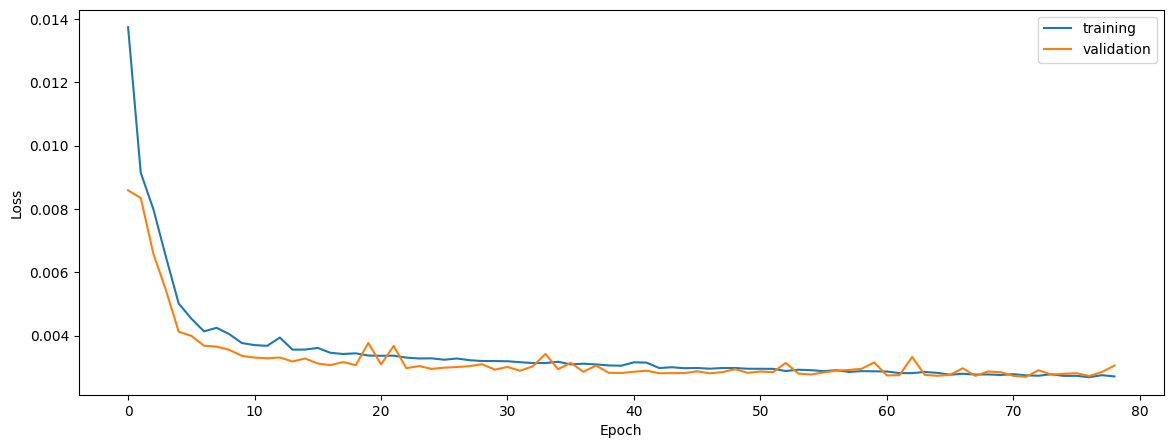

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.8435431408625584
0.8286033164900826
0.8187546000930177


In [8]:
props2 = props.copy()
props2['balance_data'] = False
props2['include_warp'] = True
gen2 = DataGenerator(**props2)
train2, val2, test2 = gen2.getData()

train_pred2 = predictInBatches(model,train2[0],architecture['batch_size'])
val_pred2 = predictInBatches(model,val2[0],architecture['batch_size'])
test_pred2 = predictInBatches(model,test2[0],architecture['batch_size'])

print('native')
print(getPearson(train2[1],train_pred2))
print(getPearson(val2[1],val_pred2))
print(getPearson(test2[1],test_pred2))

native
0.8435431408625584
0.8286033164900826
0.8187546000930177


In [9]:
print('normalized')
print(getPearson(train2[1][train2[2]],train_pred2[train2[2]]))
print(getPearson(val2[1][val2[2]],val_pred2[val2[2]]))
print(getPearson(test2[1][test2[2]],test_pred2[test2[2]]))

normalized
0.8404136469272065
0.833554093470496
0.8160502940400903


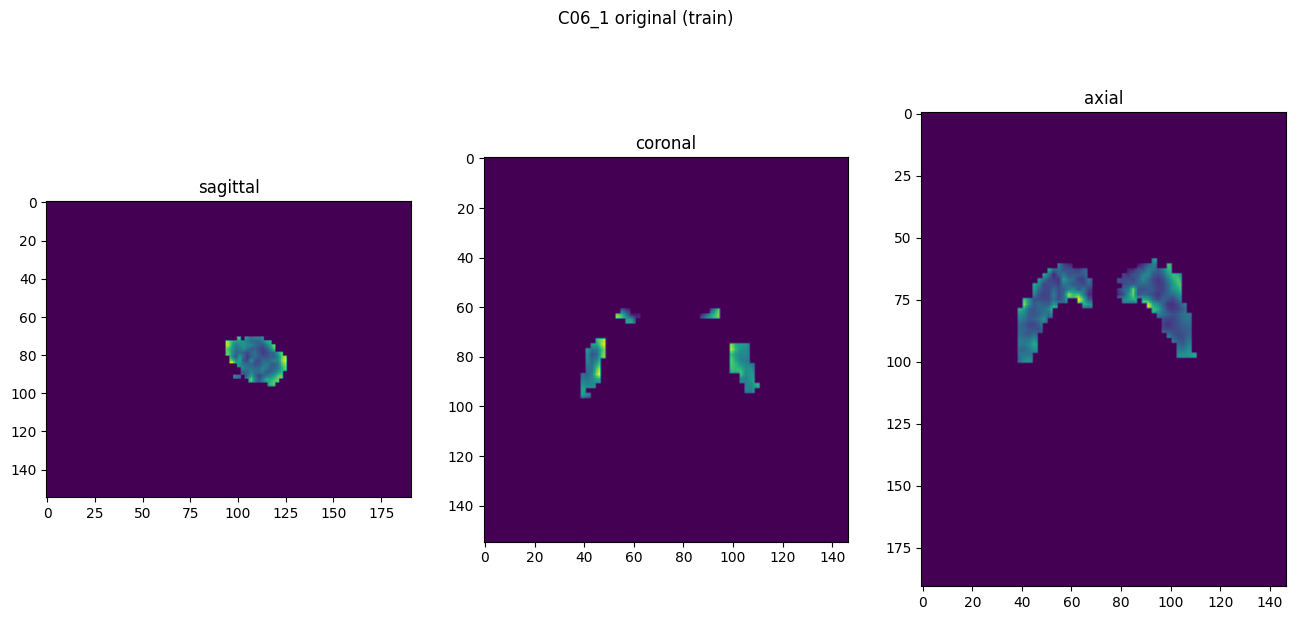

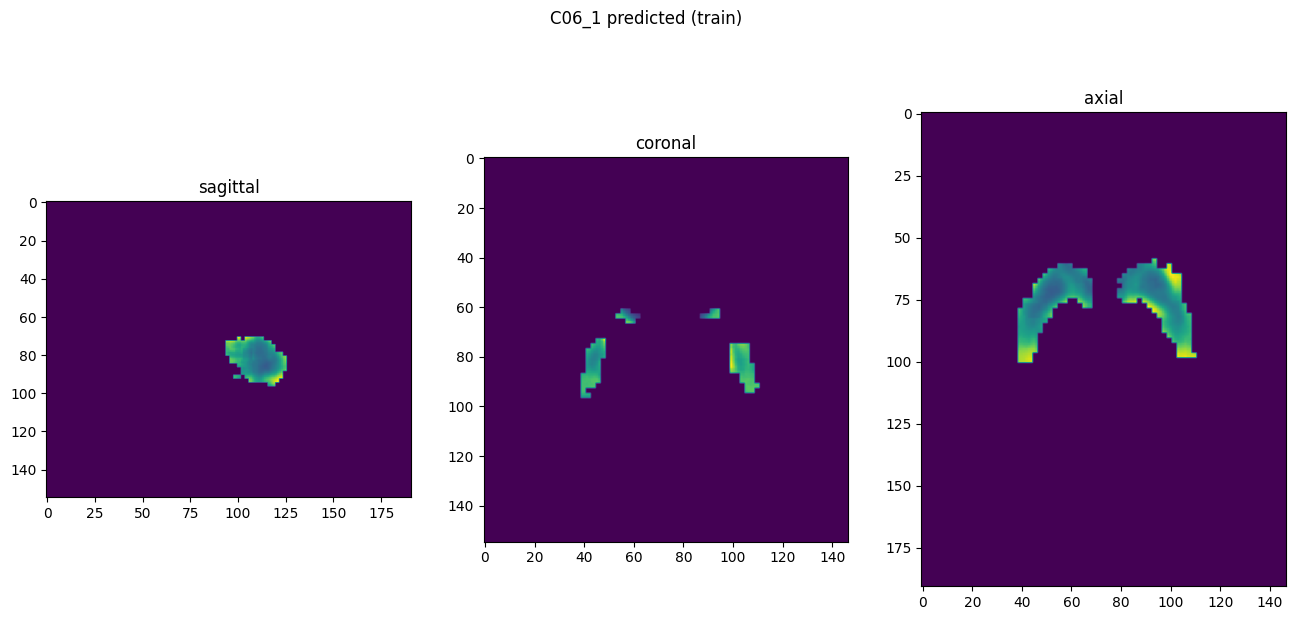

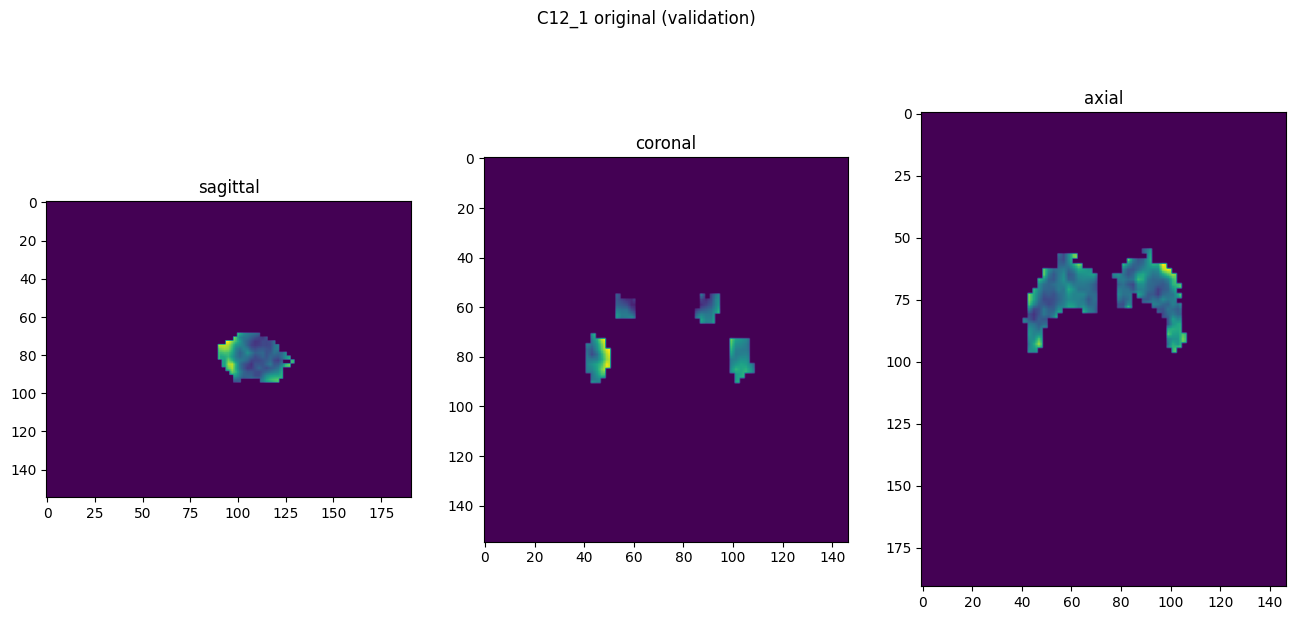

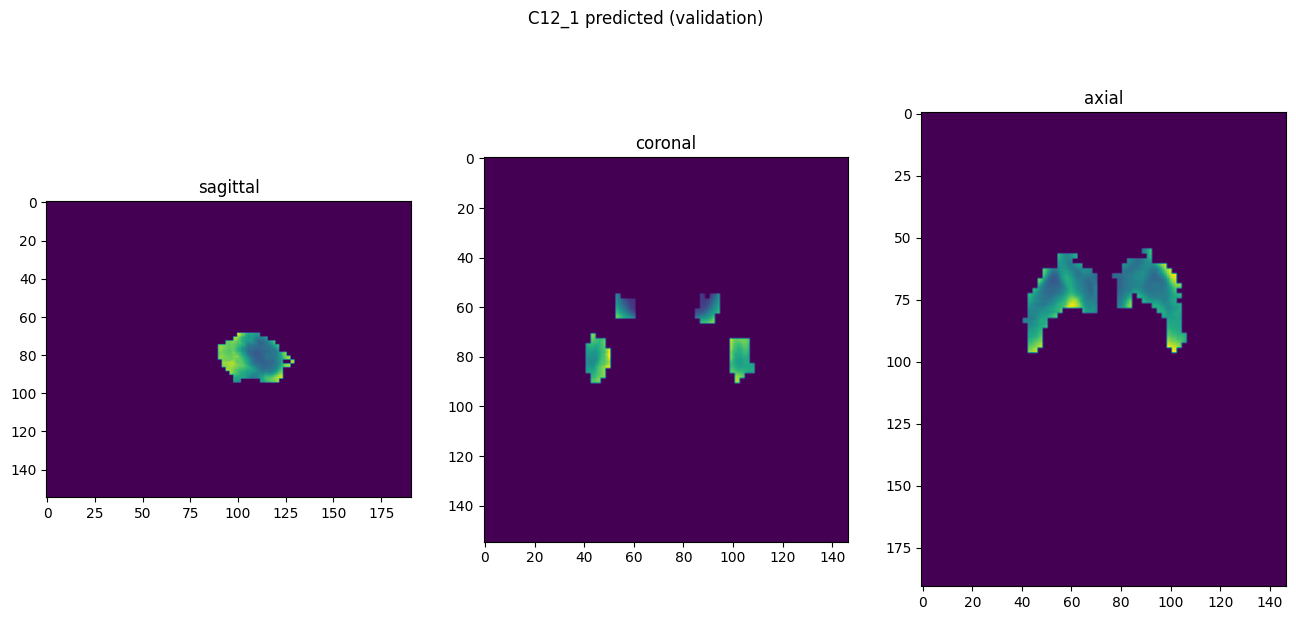

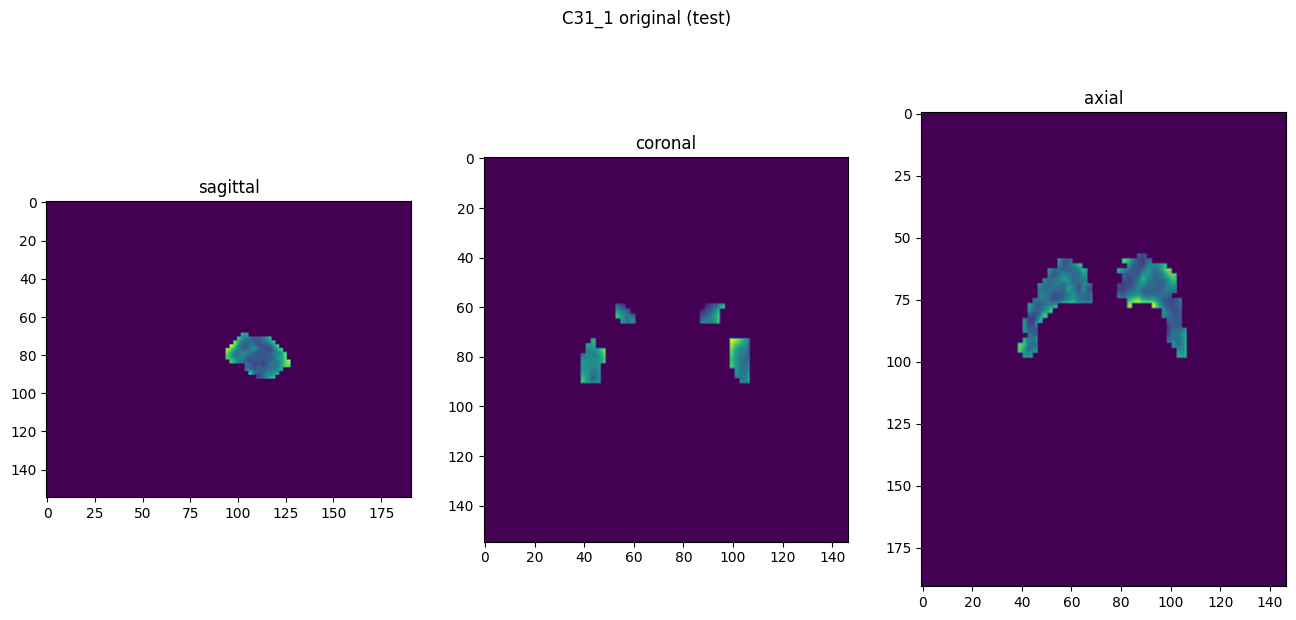

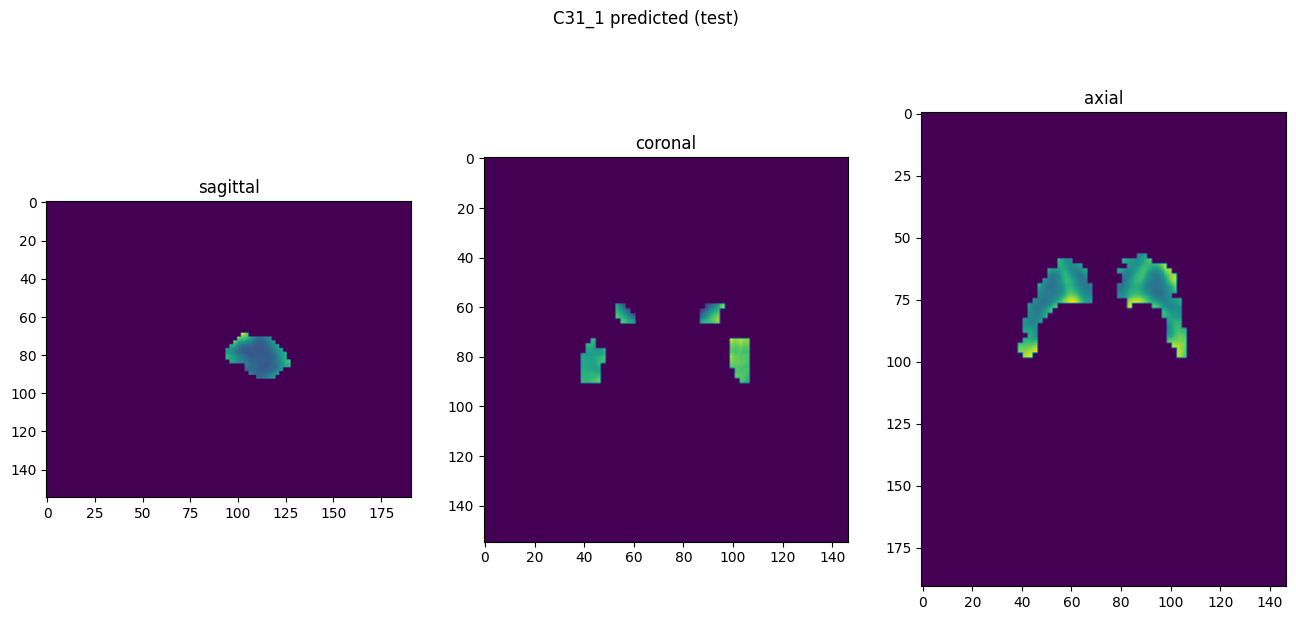

In [10]:
showResults(model, gen, threshold=None, background=False)